In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Polygon

from sentinelhub import FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataSource, HistogramType
from sentinelhub.time_utils import iso_to_datetime

In [2]:
INSTANCE_ID = '31bd9585-8cfe-4fa3-aa15-5f1b528ab12e'

In [26]:
import pygeoj
testfile = pygeoj.load(filepath="./aoi.geojson")

# my wgs84 coordinates 
aoi_wgs84 = testfile.bbox
print(aoi_wgs84)

[79.96983110904694, 7.084400873410644, 79.97372031211853, 7.08574770774949]


In [42]:
betsiboka_bbox = BBox((79.96983110904694, 7.084400873410644, 79.97372031211853, 7.08574770774949), CRS.WGS84)

In [81]:
fis_request = FisRequest(layer='__FIS_NDVI',
                        geometry_list=[betsiboka_bbox],
                        time=('2015-01-01','2019-10-31'),
                        resolution='10m',
                        instance_id=INSTANCE_ID)

In [82]:
fis_data = fis_request.get_data()

In [83]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['channel', 'date', 'min', 'max', 'mean', 'stDev']
    data = []

    for fis_response in fis_data:
        for channel, channel_stats in fis_response.items():
            for stat in channel_stats:
                row = [int(channel[1:]), iso_to_datetime(stat['date'])]

                for column in COLUMNS[2:]:
                    row.append(stat['basicStats'][column])

                data.append(row)

    return pd.DataFrame(data, columns=COLUMNS).sort_values(['channel', 'date'])


df = fis_data_to_dataframe(fis_data)

In [84]:
df.to_csv('ndvi.csv', sep=',')

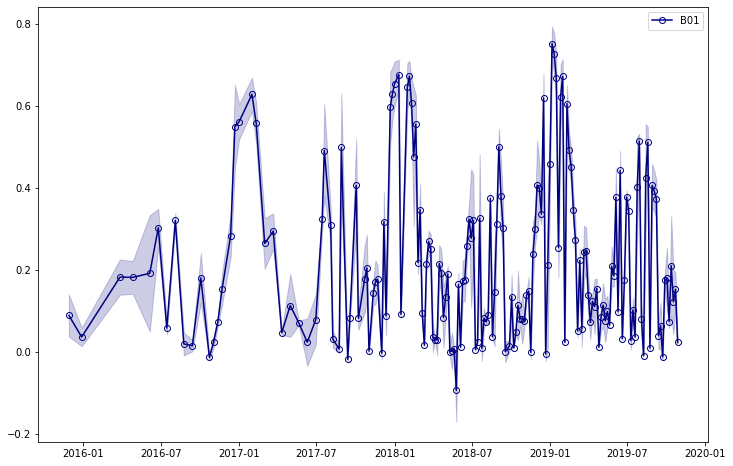

In [80]:
BANDS = 'B01'.split(',')

plt.figure(figsize=(12, 8))
for channel, (band, color) in enumerate(zip(BANDS, cm.jet(np.linspace(0, 1, 13)))):
    channel_df = df[df.channel == channel]
    plt.plot(channel_df.date, channel_df['mean'], '-o', markeredgewidth=1,
             color=color, markerfacecolor='None', label=band)
    plt.fill_between(list(channel_df.date),  channel_df['mean'] - channel_df['stDev'],
                     channel_df['mean'] + channel_df['stDev'], alpha=0.2, color=color)

plt.legend(loc='upper right');